In [2]:
# importing packages
import pandas as pd
import numpy as np
import os
import re

# nlp
import nltk
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize
import spacy
from nltk.corpus import stopwords
!python -m spacy download en_core_web_sm -q
nlp = spacy.load("en_core_web_sm")
from tqdm import tqdm
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
import string
string.punctuation
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
ps.stem('Roaming')
# download the stopword from nltk package
nltk.download('stopwords')

# Visulalize Data
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# for random forest
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


# bert
import transformers
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model

from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kanag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# loading dataset
ham_path = 'data/enron1/ham'
spam_path = 'data/enron1/spam'

def load_data(path, label):
    files = [open(os.path.join(path, file), encoding="ISO-8859-1").read() for file in os.listdir(path)]
    labeled_data = [{'Email': content, 'Type': label} for content in files]
    return labeled_data

ham = load_data(ham_path, 'ham')
spam = load_data(spam_path, 'spam')

np.random.shuffle(ham)
np.random.shuffle(spam)

combined_data = ham + spam
np.random.shuffle(combined_data) 

email_df = pd.DataFrame(combined_data)
email_df.head(7)

,Email,Type
0,"Subject: what the heck\ndaren ,\nnow what ? i ...",ham
1,"Subject: vlagra : discreet , no prescription ,...",spam
2,Subject: new intramonth book\nql ) are you goi...,ham
3,Subject: big cowboy / gepl actuals for februar...,ham
4,Subject: 11 / 00 co - owner ' s avails .\nfor ...,ham
5,"Subject: we care , no lines ! no hassle ! or e...",spam
6,Subject: new phone number & address\nthis is t...,ham


<div style="text-align: center;"> <h1>Data Preprocessing</h1> </div>

In [312]:
#check dataset's size
email_df.shape

(5172, 2)

In [313]:
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Email   5172 non-null   object
 1   Type    5172 non-null   object
dtypes: object(2)
memory usage: 80.9+ KB


<div style="text-align: left;"> <h2>Handling Null values</h2> </div>

In [314]:
email_df.isna().sum()

Email    0
Type     0
dtype: int64

<div style="text-align: left;"> <h2>Remove Duplicate Data</h2> </div>

In [315]:
email_df.groupby(email_df.duplicated(), as_index=False).size()

,index,size
0,False,4994
1,True,178


In [316]:
data_duplicated = email_df[email_df.duplicated(subset='Email', keep=False)]
data_duplicated['frequency'] = data_duplicated.groupby('Email')['Email'].transform('count')
data_duplicated.drop_duplicates(subset='Email', keep='first', inplace=True)
data_duplicated.sort_values(by='frequency', ascending=False)

,Email,Type,frequency
294,Subject: calpine daily gas nomination\n>\nrick...,ham,20
178,Subject: \n,spam,16
1425,Subject: \nthis week only : f . ree gen . erlc...,spam,3
443,Subject: you can be smart !\n,spam,3
2122,Subject: we ' ve found a school for you !\n,spam,3
...,...,...,...
750,Subject: calpine daily gas nomination\nstill u...,ham,2
717,Subject: fwd :\nyour needed soffttwares at roc...,spam,2
705,"Subject: spot deals - april , 2001\nthe follow...",ham,2
686,Subject: cornhusker\nthanks for following up o...,ham,2


In [317]:
# dropping duplicate values
email_df.drop_duplicates(subset='Email', keep='first', inplace=True)
email_df.groupby(email_df.duplicated(), as_index=False).size()

,index,size
0,False,4994


In [318]:
# creating numerical repersentation of Type - one hot encoding
email_df.loc[:,'label']=email_df.Type.map({'ham':0, 'spam':1})
#convert 'points' column to integer
email_df['label'] = email_df['label'].astype(str).astype(int)

# drop type column
email_df = email_df.drop('Type', axis=1)

In [319]:
email_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4994 entries, 0 to 5171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Email   4994 non-null   object
 1   label   4994 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 97.5+ KB


<div style="text-align: center;"> <h1>Exploratory Data Analysis (EDA)</h1> </div>

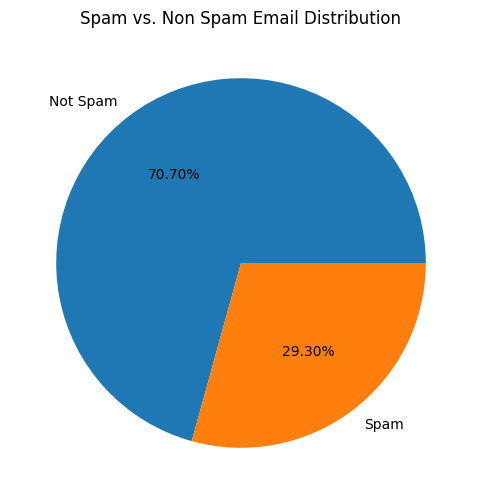

In [320]:
plt.figure(figsize=(14,6))
# pie chart
plt.pie(email_df['label'].value_counts(),labels=['Not Spam','Spam'],autopct='%1.2f%%')
plt.title("Spam vs. Non Spam Email Distribution")
plt.savefig('images/Spam_vs_Notspam.png', bbox_inches='tight')
plt.show()

In [321]:
email_df['label'].value_counts()

label
0    3531
1    1463
Name: count, dtype: int64

**Comments:**
The dataset is imbalanced due to that it has more "Non Spam" values than "spam" values. This imbalance may cause us to make weak predictions.

In [322]:
# number of characters in a email
email_df['num_characters']=email_df['Email'].apply(len) 
email_df.rename(columns={'num_characters':'Character Count'},inplace=True)

## Breaking sentence into number of words
email_df['Word Count'] = email_df['Email'].apply(lambda x:len(nltk.word_tokenize(x)))
email_df.head(4)

## Counting number of words used in a Email
email_df['Sentence Count']=email_df['Email'].apply(lambda x:len(nltk.sent_tokenize(x)))


In [323]:
# Describe function for Not Spam Messages
email_df[email_df['label'] == 0][['Character Count','Word Count','Sentence Count']].describe()

,Character Count,Word Count,Sentence Count
count,3531.000000,3531.000000,3531.000000
mean,977.089776,230.516001,11.662419
std,1380.153944,337.018933,25.330035
min,17.000000,3.000000,1.000000
25%,236.000000,53.000000,4.000000
50%,528.000000,128.000000,7.000000
75%,1230.000000,298.500000,13.500000
max,31860.000000,8863.000000,1204.000000


In [324]:
# Describe function for Spam Messages
email_df[email_df['label'] == 1][['Character Count','Word Count','Sentence Count']].describe()

,Character Count,Word Count,Sentence Count
count,1463.000000,1463.000000,1463.000000
mean,1229.324675,241.849624,17.562543
std,1814.232891,349.816023,33.066860
min,10.000000,2.000000,1.000000
25%,299.000000,60.000000,4.000000
50%,579.000000,120.000000,9.000000
75%,1278.000000,254.000000,19.000000
max,21749.000000,3963.000000,691.000000


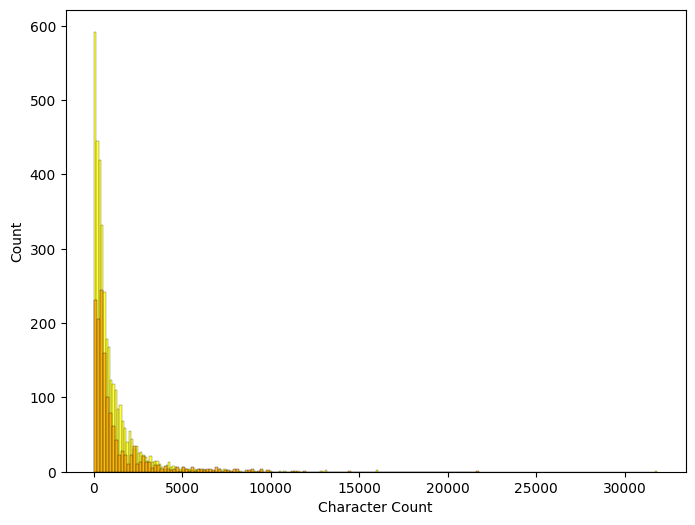

In [325]:
# Histogram plot for character count
plt.figure(figsize=(8,6))
sns.histplot(email_df[email_df['label']==0]['Character Count'],color = 'yellow')
sns.histplot(email_df[email_df['label']==1]['Character Count'],color = 'orange')
plt.show()

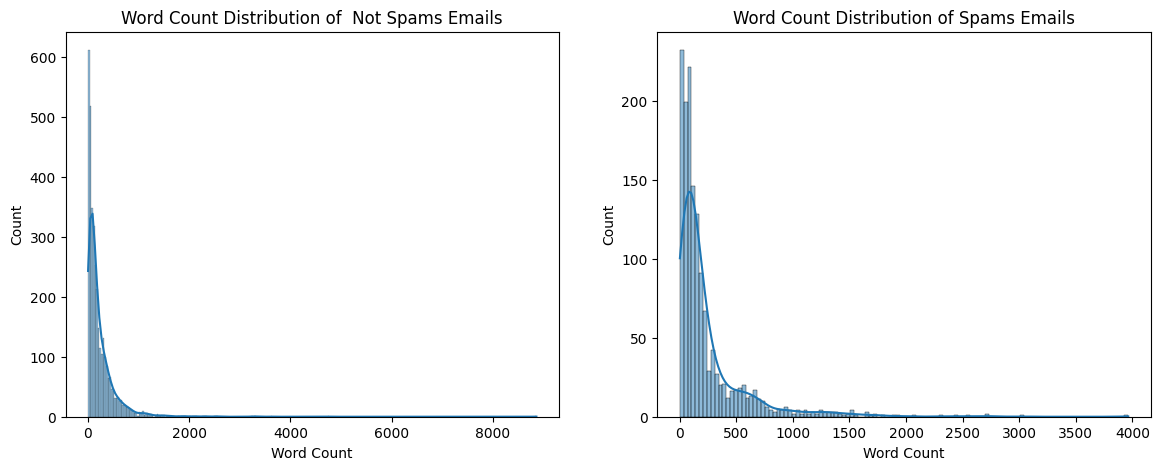

In [326]:
# Histogram plot for word count
fig, axes = plt.subplots(nrows= 1, ncols=2, figsize=(14,5))
sns.histplot(email_df[email_df['label']== 0]['Word Count'], kde = True, ax=axes[0]).set(title='Word Count Distribution of  Not Spams Emails')
sns.histplot(email_df[email_df['label']== 1]['Word Count'], kde = True, ax=axes[1]).set(title='Word Count Distribution of Spams Emails')
plt.subplots_adjust(wspace=0.2)
plt.savefig('images/word_count_distribution_Spam_vs_Notspam.png', bbox_inches='tight')
plt.show()

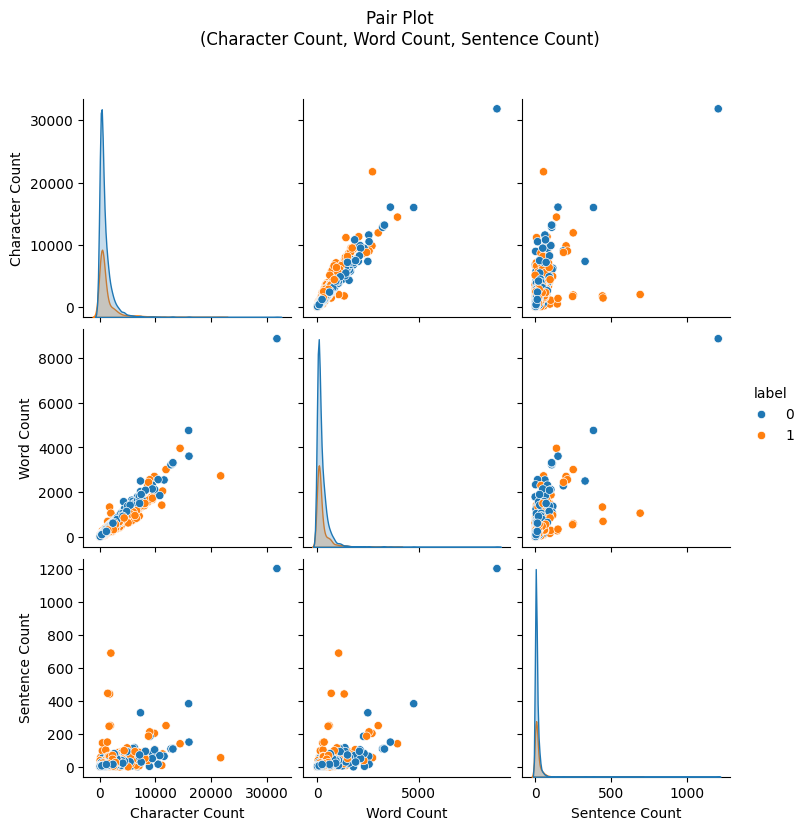

In [327]:
# pair plot
sns.pairplot(email_df,hue='label')
plt.suptitle('Pair Plot\n(Character Count, Word Count, Sentence Count)', y=1.1)
plt.savefig('images/pair_plot.png', bbox_inches='tight')
plt.show()

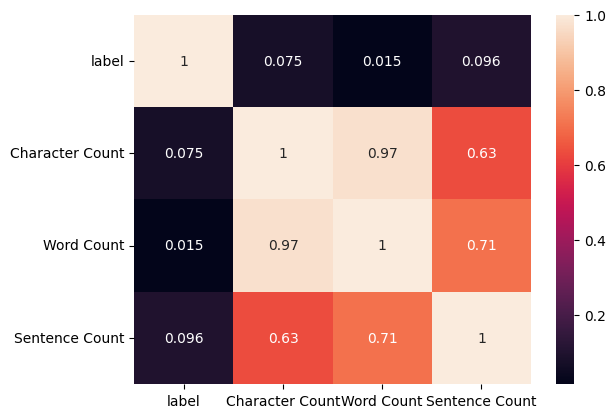

In [328]:
# Select only numeric columns
columns_to_select = ['label', 'Character Count', 'Word Count', 'Sentence Count'] 
numeric_data = email_df[columns_to_select]

## Heat map plot
sns.heatmap(numeric_data.corr(),annot=True)
plt.show()

In [329]:
def clean_text(text):
    text = text.lower() # 1. Lower Case Convertion
    text = nltk.word_tokenize(text) # 2. Tokenization
    
    y=[] # 3. Removing special Characters
    for i in text:
        if i.isalnum():
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text: # 4. Removing stop words and punctuation
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:  # 5. Stemmimg
        y.append(ps.stem(i))
        
    return " ".join(y)

In [330]:
email_df['clean_email']=email_df['Email'].apply(clean_text)

In [331]:
spam_word = []
for msg in email_df[email_df['label']==1]['clean_email'].tolist():
    for word in msg.split():
        if word != 'subject':
            spam_word.append(word)

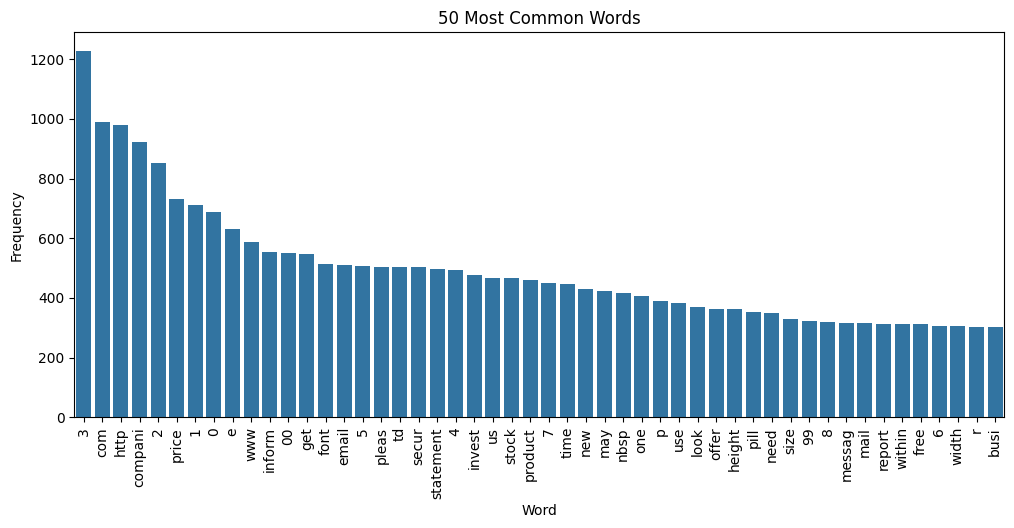

In [358]:
# bar plot to find most commonly used words in spam email
data_frame = pd.DataFrame(Counter(spam_word).most_common(50), columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 5))
sns.barplot(x='Word', y='Frequency', data=data_frame)
plt.title('50 Most Common Words')
plt.xticks(rotation=90)
plt.savefig('images/50_Most_Common_Words_in_spam_emalis.png', bbox_inches='tight')
plt.show()

**Applying Downsampling:**

In [333]:
# check percentage of data - states how much data needs to be balanced
print(str(round(1463/4994,2))+'%')


0.29%


In [334]:
# creating 2 new dataframe as df_ham , df_spam
df_spam = email_df[email_df['label']== 1]
df_ham = email_df[email_df['label']== 0]

print("Ham Dataset Shape:", df_ham.shape)
print("Spam Dataset Shape:", df_spam.shape)

Ham Dataset Shape: (3531, 6)
Spam Dataset Shape: (1463, 6)


In [335]:
# apply down sampling
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(1463, 6)

In [336]:
# concating both dataset - df_spam and df_ham_balanced to create df_balanced dataset
email_balanced_df = pd.concat([df_spam , df_ham_downsampled])
email_balanced_df['label'].value_counts()

label
1    1463
0    1463
Name: count, dtype: int64

In [337]:
email_balanced_df.sample(5)

,Email,label,Character Count,Word Count,Sentence Count,clean_email
592,Subject: your prescription is ready . . oxwq s...,1,451,88,12,subject prescript readi oxwq f e low cost pres...
3901,"Subject: hpl nom for april 18 , 2001\n( see at...",0,94,24,3,subject hpl nom april 18 2001 see attach file ...
5167,Subject: re : gtsak\niko http : / / szeb . low...,1,89,25,3,subject gtsak iko http szeb loweredr 4 u com 4...
2022,Subject: uiccib new generic viarga . special f...,1,334,55,5,subject uiccib new gener viarga special paliou...
4878,Subject: discover you made money while you wer...,1,994,205,21,subject discov made money sleep aaer xchxa mus...


<div style="text-align: center;"> <h1>Modeling</h1> </div>

In [338]:
# spliting data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(email_balanced_df['Email'], email_balanced_df['label'])

**Random Forest:**

In [340]:
# creating pipeline
pipe = Pipeline(
    [
        ("vec", text.TfidfVectorizer()),
        ("model", RandomForestClassifier())
    ]
)

In [341]:
# The randomized search
params = {
    # vectorizer params
    "vec__sublinear_tf": [True, False],
    "vec__max_features": [None, *range(100, 1000, 100)],
    "vec__ngram_range": [(1, 1), (1, 2), (2, 2), (2, 3), (3, 3)],
    "vec__strip_accents": ["unicode", "ascii", None],
    "vec__norm": ["l1", "l2"],
    "vec__stop_words": ["english", None],
    
    # model params
    "model__criterion": ["gini", "entropy"],
    "model__n_estimators": [*range(100, 800, 100)],
    "model__n_jobs": [-1],
}

grid = RandomizedSearchCV(pipe, params, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__n_estimators': [100, 200, 300,
                                                                400, 500, 600,
                                                                700],
                                        'model__n_jobs': [-1],
                                        'vec__max_features': [None, 100, 200,
                                                              300, 400, 500,
                                                              600, 700, 800,
                                                              900],
                                        'vec__ngram_range': [(1, 1), (1, 2),
                                                             (2, 2), (2, 3),
                                                             (3, 3)],
                                        'vec__norm': ['l1', 'l2'],
                                        'vec__stop_words': ['english', None],
                                        'vec__strip_accents': ['unicode',
                                                               'ascii', None],
                                        'vec__sublinear_tf': [True, False]})

In [342]:
# Check the best parameter values.
print("Best params:")
print(grid.best_params_)

print("Best Score:", grid.best_score_)

Best params:
{'vec__sublinear_tf': True, 'vec__strip_accents': 'unicode', 'vec__stop_words': None, 'vec__norm': 'l2', 'vec__ngram_range': (1, 1), 'vec__max_features': 600, 'model__n_jobs': -1, 'model__n_estimators': 300, 'model__criterion': 'gini'}
Best Score: 0.963992707383774


In [344]:
# best estimator is our model.
model_rf = grid.best_estimator_
# Predict on the test set
y_pred_random_forest = model_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_random_forest))

Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       376
           1       0.94      0.99      0.96       356

    accuracy                           0.96       732
   macro avg       0.96      0.96      0.96       732
weighted avg       0.96      0.96      0.96       732



**BERT:**

In [346]:
# selecting pre-trained model for tokenization
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

In [347]:
# loading bert model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [348]:
# creating function to encode the dataset with tokenizer
def encode(text, maxlen):
  input_ids=[]
  attention_masks=[]

  for row in text:
    encoded = tokenizer.encode_plus(
        row,
        add_special_tokens=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_attention_mask=True,
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)

In [349]:
# generating train and test datasets based on encodings
X_train_input_ids, X_train_attention_masks = encode(X_train.values, maxlen=64)
X_test_input_ids, X_test_attention_masks = encode(X_test.values, maxlen=64)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [350]:
# bulding bert model
input_word_ids = tf.keras.Input(shape=(64,),dtype='int32')
attention_masks = tf.keras.Input(shape=(64,),dtype='int32')

sequence_output = bert_model([input_word_ids,attention_masks])
output = sequence_output[1]
output = tf.keras.layers.Dense(32,activation='relu')(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

model_bert = tf.keras.models.Model(inputs = [input_word_ids,attention_masks], outputs = output)
model_bert.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model_bert.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_11[0][0]',               
                                thPoolingAndCrossAt               'input_12[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                          

In [351]:
# training the model for 5 epoch
history = model_bert.fit(
    [X_train_input_ids, X_train_attention_masks],
    y_train,
    batch_size=32,
    epochs=5,
    validation_data=([X_test_input_ids, X_test_attention_masks], y_test),
    class_weight={0: 1, 1: 1})
     

Epoch 1/5
69/69 [==============================] - 613s 9s/step - loss: 0.3668 - accuracy: 0.8459 - val_loss: 0.2765 - val_accuracy: 0.8975
Epoch 2/5
69/69 [==============================] - 639s 9s/step - loss: 0.1256 - accuracy: 0.9617 - val_loss: 0.0925 - val_accuracy: 0.9713
Epoch 3/5
69/69 [==============================] - 629s 9s/step - loss: 0.0555 - accuracy: 0.9886 - val_loss: 0.1064 - val_accuracy: 0.9740
Epoch 4/5
69/69 [==============================] - 22963s 338s/step - loss: 0.0405 - accuracy: 0.9900 - val_loss: 0.0767 - val_accuracy: 0.9768
Epoch 5/5
69/69 [==============================] - 632s 9s/step - loss: 0.0289 - accuracy: 0.9927 - val_loss: 0.0743 - val_accuracy: 0.9781


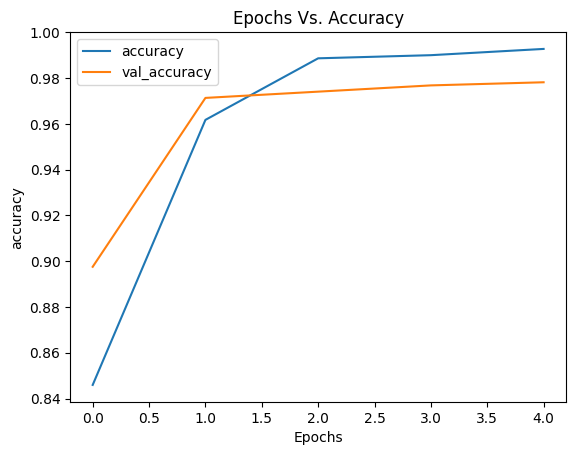

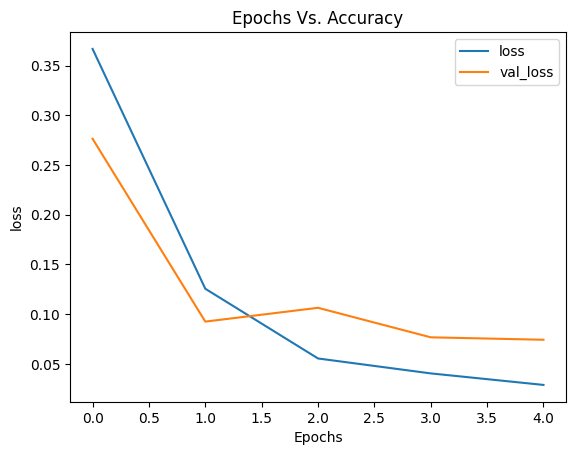

In [357]:
# visualizing training 
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title("Epochs Vs. Accuracy")
  plt.savefig('images/Epochs_Vs_Accuracy.png', bbox_inches='tight')
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [353]:
loss, accuracy = model_bert.evaluate([X_test_input_ids, X_test_attention_masks], y_test)
print('Test accuracy :', accuracy)

23/23 [==============================] - 57s 2s/step - loss: 0.0743 - accuracy: 0.9781
Test accuracy : 0.9781420826911926


In [354]:
y_pred = model_bert.predict([X_test_input_ids, X_test_attention_masks])
y_pred_bert = np.where(y_pred > 0.5 , 1, 0)

23/23 [==============================] - 56s 2s/step


In [355]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_bert))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       376
           1       0.97      0.99      0.98       356

    accuracy                           0.98       732
   macro avg       0.98      0.98      0.98       732
weighted avg       0.98      0.98      0.98       732

